REQUEST GENERATION


In [ ]:

from collections import deque
import numpy as np
import time
import pickle
from pathlib import Path

class StaticZipf:
    def __init__(self, L, a):
        """
        L is the Library Size
        a is the shape parameter of the Zipf distribution
        """
        self.L = L
        self.a = a
        self.prob = self.zipf(L, a)

    def req_gen(self, count):
        """
        Generates the 'count' no. of requests according to self.prob
        """
        items = list(range(self.L))
        req = np.random.choice(items, p = self.prob, size = count)
        return req

    def zipf(self, n, a):
        """
        n is the size
        a is the shape factor
        pdf of X, fx(X) = c/(x^a) where c = summation of (1/i)^a where i runs from 1 to n
        To get the top one element one has to substitute x = 1 and vice versa
        """
        x = sum([(1/i)**a for i in range(1,n+1)])
        y = [None]*n
        for i in range(n):
            y[i] = (1/(i+1)**a)*(1/x)
        return np.array(y)

    def rotatetop(self, y, top, step, direction):
        """
        y is the array to cyclically shift the first top elements by step.
        step: amount which the we have to shift
        direction: +1/-1 right or left
        """
        s = deque(y[:top])
        s.rotate(direction*step)
        return np.array(list(s)+list(y[top:]))



def szipf(L=100, count=10_000, a=1, silent=True):
    """
    Generates the static zipf requests

    Refer to the Static Zipf Class to understand variables
    Returns the prob distribution and generated requests dictionary
    """

    start = time.time()

    szipf = StaticZipf(L=L, a=a)
    prob = szipf.prob
    req = szipf.req_gen(count)

    if not silent:
        print(f'TimeTaken:{time.time() - start} sec')

    return {'prob':prob, 'req':req}


def dzipf(L=100, count=10_000, req_step=1000, window=50, top=10, cache_size=10, a=1, silent=True):
    """
    Generates the dynamic zipf requests

    Refer to the Static Zipf Class to understand variables
    req_step: no. of requests after which popularity changes
    window: no. of most popular items for which the popularities are changed
    top: the no. of item's popularities are moved to left or right
    Returns the generated requests and optimal cache
    """

    # Input checking
    if not np.all([window < L, top < window, count % req_step == 0, top < L]):
        raise ValueError("Input arguments are not valid")

    start = time.time()

    count_step = int(count/req_step)

    szipf = StaticZipf(L=L, a=a)
    optimcache = np.zeros((count_step*cache_size)).astype(int)
    req = np.zeros((count,)).astype(int)
    for i in range(count_step):
        optimcache[cache_size*i:cache_size*(i+1)] = np.argsort(szipf.prob)[::-1][:cache_size]
        req[req_step*i:req_step*(i+1)] = szipf.req_gen(req_step)
        szipf.prob = szipf.rotatetop(szipf.prob, window, top, 1)

    if not silent:
        print(f'TimeTaken:{time.time() - start} sec')

    return {'optim_cache':optimcache, 'req':req}

# Netflix Data is collected between 1998 and 2005
# Library Size - 17, 770
# Requests logs processed - 10_04_80_507
def netflix(count=10_000, silent=True):
    """
    Loads the popularity profile from netflixdata file and generates the requests

    count: No. of requests to be generated
    Returns the prob distribution and generated requests dictionary
    """
    curr_path = Path(__file__).resolve().parents[1]
    data_path = Path("./data/netflixdata.pkl")

    with open(curr_path / data_path,'rb') as f:
        popularity_dic = pickle.load(f)

    items = list(popularity_dic.keys())
    prob = list(popularity_dic.values())

    start = time.time()
    # Random sampling
    req = np.random.choice(items, p = prob, size = count)
    if not silent:
        print(f'TimeTaken:{time.time()-start}sec')
    return {'prob':prob, 'req':req}


# Library Size - 1,61,085
def youtube(count=10_000, silent=True):
    """
    Loads the popularity profile from youtube data file and generates the requests

    count: No. of requests to be generated
    Returns the prob distribution and generated requests dictionary
    """
    curr_path = Path(__file__).resolve().parents[1]
    data_path = Path("./data/youtubedata.pkl")

    start = time.time()
    with open(curr_path / data_path,'rb') as f:
        prob = pickle.load(f)

    items = list(range(prob.shape[0]))
    # Random Sampling
    req = np.random.choice(items, p = prob, size = count)
    if not silent:
        print(f'TimeTaken:{time.time()-start}sec')
    return {'prob':prob, 'req':req}

LU

In [ ]:
import numpy as np
from collections import deque
import math
import random

In [ ]:

import numpy as np
from collections import deque
import math
import random

# Least Frequently Used
class LFU:
    def __init__(self, L, cache_size):
        """
        L : Library size
        cache_size: Size of the Cache
        """
        self.arr = np.zeros((L,)) #intialises the counters array of size = library size
        self.cache_size = cache_size
        self.prob = np.zeros((L,)) # Stores the probability distribution of the library items

    def update(self, req):
        """
        Updates the counter of library items
        req: request
        """
        self.arr[req] += 1

    def currcache(self, Return = True, exclude = []):
        """
        To find the cache using LFU
        exclude: items that are to be excluded from the library while finding cache
        Return: True - returns the current cache or False - doesn't return
        Returns the current cache according to the popularity
        """
        distrib = self.arr/np.sum(self.arr)
        self.prob = distrib
        if len(exclude) != 0 :
            distrib[exclude] = 0
        if Return:
            return np.argsort(distrib)[::-1][:self.cache_size]

    def popularity(self):
        """
        Returns the popularity of the items in the Library
        """
        return self.prob

    def counters_used(self):
        """
        Returns no. of counters used till now
        """
        return np.count_nonzero(self.arr)

# Window LFU
class WLFU:
    def __init__(self, L, cache_size, window=None, F=[]):
        """
        window: Size of the window
        L: Library size
        F: Freshness constraints of the library items and size = L
        cache_size: Cache Size
        """
        if window == None:
            self.window = int(cache_size*cache_size*math.log(L))
        else:
            self.window = window
        self.L = L
        self.cache_size = cache_size

        # Checking whether we need to take F into consideration
        if len(F) == 0:
            self.state = False
        else:
            self.state = True
            # divided by window to normalize the Freshness constriants
            self.F = np.array(F)/self.window


        #deque internally uses double linked list
        self.q = deque(i for i in np.random.randint(L, size = self.window)) # Randomly intialised deque of size window upto L integers
        self.dic = {}

        # Random initialization of the deque
        if not self.state:
            for i in self.q:
                if i in self.dic:
                    self.dic[i] += 1
                else:
                    self.dic[i] = 1
        else:
            for i in self.q:
                if i in self.dic:
                    self.dic[i] += self.F[i]
                else:
                    self.dic[i] = self.F[i]

    def update(self, req):
        """
        Updates the counter deque used in WLFU
        req: request
        """

        #appends the new request to the deque
        self.q.appendleft(req)

        #removes the last request from the deque
        rem = self.q.pop()

        #Decreasing the count or removing the request
        if not self.state:
            if self.dic[rem] == 1:
                del self.dic[rem]
            else:
                self.dic[rem] -= 1
        else:
            if self.dic[rem] == self.F[rem]:
                del self.dic[rem]
            else:
                self.dic[rem] -= self.F[rem]

        #Increasing the count or appending the request
        if not self.state:
            if req in self.dic:
                self.dic[req] += 1
            else:
                self.dic[req] = 1
        else:
            if req in self.dic:
                self.dic[req] += self.F[req]
            else:
                self.dic[req] = self.F[req]

    def currcache(self):
        """
        to find the cache according frequency of items in window
        Returns the current cache
        """

        sort_arr = dict(sorted(self.dic.items(), key= lambda x:x[1], reverse = True)[:self.cache_size]).keys()
        return np.array(list(sort_arr))


class LFULite:
    def __init__(self, L, cache_size, window=None, F=[]):
        """
        window: window size of WLFU
        L: Library Size
        cache_size: Cache Size
        F: Freshness Constraints of the library items
        """
        self.L = L
        self.cache_size = cache_size
        self.counterbank = {} # Consists of key as video ID and value as list of [time, number of occurences]
        self.wlfu = WLFU(L=L, cache_size=cache_size, F=F, window=window)
        self.prob = {} # Item id and it's probability

    def update(self, req, ithreq, wlfu = True):
        """
        Update the counterbank and counter in WLFU
        req: request
        wlfu: whether to update the wlfu counter bank or not
        ithreq: no. of request algorithm processed so far
        """
        #Update the counter of the WLFU
        if wlfu:
            self.wlfu.update(req)

        #most frequent items in the window
        currtop = self.wlfu.currcache()

        #If present in the counterbank it increases the count.
        if req in self.counterbank:
            self.counterbank[req][1] += 1

        #Appending the elements that are not in counterbank
        for j in list(currtop):
            if j not in self.counterbank:
                self.counterbank[j] = [ithreq+1,1]

    def currcache(self, ithreq, Return = True, exclude = []):
        """
        to find the cache according to LFULite
        ithreq: how many request that are given to the algorithm till now
        exclude: items to be excluded while calculating the cache
        Return: True - returns the current cache or False - doesn't return
        Returns the current cache
        """
        if ithreq > 0:
            arr = {i:0 for i in self.counterbank}
            for k in arr:
                # Caluclating the popularity distribution of the elements that we added before this time.
                if self.counterbank[k][0] != (ithreq+1):
                    # Counting the appearnces after it is been added to the counterbank
                    arr[k] = (self.counterbank[k][1]-1)/((ithreq+1)-self.counterbank[k][0])
                self.prob = arr

            # For excluding some library item's in the cache
            if len(exclude) != 0:
                # it will assign 0
                arr.update(dict.fromkeys(exclude, 0))

            sort_arr = dict(sorted(arr.items(), key= lambda x:x[1], reverse = True)[:self.cache_size]).keys()
            if Return:
                return np.array(list(sort_arr))
        else:
            if Return:
                return np.array(list(self.counterbank.keys()))

    def popularity(self):
        "Return the popularity of the items in the counterbank"
        return self.prob

    def counters_used(self):
        """
        Returns no. of counters used till now
        """
        return len(self.counterbank)

class CountSketch:
    def __init__(self, l, b, L):
        """
        t: No. of random functions for each s and h
        b: No. of objects that h has to map from L
        L: Library Size
        """
        self.l = l
        self.b = b
        self.L = L
        self.h, self.s = self.createmap()
        self.cs = np.zeros((l,b))
        # Cache is of size C but as we are using zipf with parameter 1. C = b
        self.cache = []

    def randomassign(self, num, bi = False):
        """
        Generates random mapping value for mapping function
        num: no. of different mapping values
        bi: True - +1 or -1 and False - 1 to num (both inclusive)
        Returns generated random number in the given range
        """
        if bi:
            n = random.random()
            if(n > 0.5):
                return 1
            else:
                return -1
        else:
            return int(random.randint(1, num))

    def createmap(self):
        """
        Creates l number of h and s mapping functions for each library item.
        Return h and s mapping functions
        """
        h = {i:[] for i in range(self.L)}
        s = {i:[] for i in range(self.L)}

        # Creating l number of h functions
        for _ in range(self.l):
            for i in range(self.L):
                n = self.randomassign(self.b)
                h[i].append(n)

        # Creating l number of s functions
        for _ in range(self.l):
            for i in range(self.L):
                n = self.randomassign(2, True)
                s[i].append(n)

        return h,s

    def update(self, req):
        """
        Updates the cs counters which is a t*b array
        req: Request
        """
        for i in range(self.l):
            self.cs[i,self.h[req][i]-1] += self.s[req][i]

    def estimate(self, req):
        """
        Calculates the estimate of the requested item by finding median hi[r(t)]*si[r(t)]
        req: Request
        """
        med = np.zeros((self.l,))
        for i in range(self.l):
            med[i] = self.cs[i,self.h[req][i]-1]*self.s[req][i]
        return np.median(med)

    def min_est(self):
        """
        Calculates the minimum estimate of the cache and it's position
        Returns position and minimum value
        """
        arr = np.zeros((len(self.cache),))
        for i,j in enumerate(self.cache):
            arr[i] = self.estimate(j)
        index = np.argmin(arr)

        return index, arr[index]

    def currcache(self, req):
        """
        Updates the cs counter and inserts the request into the cache
        req: Request
        Returns the current cache
        """
        self.update(req)
        # If length of cache is less than b and not in cache.
        if(len(self.cache)<self.b and req not in self.cache):
            # Adding the request to the cache
            self.cache.append(req)
        elif(req not in self.cache):
            # Finding the estimate of the request
            req_est = self.estimate(req)
            # Adding the new request and removing the min_est item from the cache
            ind, est = self.min_est()
            if req_est > est:
                self.cache[ind] = req

        return np.array(self.cache)

# Least Recently Used
class LRU:
    def __init__(self, cache_size, L):
        """
        cache_size: Cache Size
        L: Library Size
        """
        self.cache_size = cache_size
        self.L = L
        self.cache = random.sample(range(1,L+1), cache_size)

    def update(self, req):
        """
        Updates the elements in the cache
        req: request
        """
        currcache = self.cache

        # If present in the cache, bring the item to the begining of the list
        if req in self.cache:
            currcache.remove(req)
            self.cache = [req] + currcache
        # else remove the last element of the list and insert in the first position.
        else:
            _ = currcache.pop()
            currcache.insert(0, req)
            self.cache = currcache

    def __contains__(self, req):
        """
        Magic method to use "in" keyword
        req: request
        """
        if req in self.cache:
            return True
        else:
            return False

    def currcache(self):
        "Returns the current cache"
        return self.cache

# Least Useful: Refer LFU, LFULite and WLFU algorithms to understand.
class LU:
    def __init__(self, L, F, cache_size, arr = [], method = '', useF = False, freqtop=None, window=None):
        """
        L: Library Size
        F: Freshness constant array of size L
        cache_size: Size of the cache for the algorithm
        freqtop: No. of the most frequent elements wlfu needs to consider
        useF: use of F for WLFU
        window: window size of the WLFU
        arr: probability of library ites in case of LU algorithm.
        method: 'lfu' or 'lfulite': Default is 'lfu' if arr is not given
        """
        self.F = {i:j for i, j in enumerate(F)}
        self.L = L
        self.cache_size = cache_size
        self.method = method

        # self.calpop determines whether we have to calculate popularity or not
        self.calpop = True if len(arr) == 0 else False

        # self.arr counter for the library items
        # self.prob contains the probabilty of items used by the algorithm
        if not self.calpop:
            self.prob = np.array(arr)
        elif self.method == 'lfu':
            self.arr = np.zeros((L,))
            self.prob = np.zeros((L,))
        elif self.method == 'lfulite': # LFU-Lite maintains the popularity of the items only in the counter bank
            self.arr = {} # Consists of key as video ID and value as list of [time, number of occurences]
            if useF:
                self.wlfu = WLFU(L=L, cache_size=freqtop, F=F, window=window)
            else:
                self.wlfu = WLFU(L=L, cache_size=freqtop, window=window)
            self.prob = {}
        # self.fetchtime stores the time at which cache elements are fetched
        self.fetchtime = {}

    def update(self, req, ithreq = None):
        """
        Updates the counters of the items used in the algorithm
        req: Request
        ithreq: no. of request algorithm processed so far
        """

        if self.method == 'lfu':
            self.arr[req] += 1
        elif self.method == 'lfulite':
            # finds the most frequent items according to WLFU
            self.wlfu.update(req)
            currtop = self.wlfu.currcache()
            if req in self.arr:
                self.arr[req][1] += 1

            for j in currtop:
                if j not in self.arr:
                    self.arr[j] = [ithreq+1, 1]

    def cache_update(self, req, time):
        """
        Updates the cache based on the request and it's arrival time
        req: Request
        time: arrival time of the request
        """
        v = {}

        for i in self.fetchtime:
            v[i] = self.prob[i]*(self.fetchtime[i]+self.F[i] - (time+1))

        minind = min(v, key=v.get) # Gives the key with minimum value

        if (self.prob[req]*self.F[req]) > v[minind]:
            self.fetchtime.pop(minind)
            self.fetchtime[req] = (time+1)

    def popularity_update(self, req, ithreq):
        """
        Calculates and updates the popularity of the items used in the algorithm
        req: Request
        ithreq: no. of request algorithm processed so far
        """
        self.update(req, ithreq = ithreq)
        if self.method == 'lfu':
            distrib = self.arr/np.sum(self.arr)
        elif self.method == 'lfulite':
            distrib = {i:0 for i in self.arr}
            for k in distrib:
                if self.arr[k][0] != (ithreq+1):
                    distrib[k] = (self.arr[k][1]-1)/((ithreq+1)-self.arr[k][0])
        self.prob = distrib

    def currcache(self, req, time, ithreq = None):
        """
        Calculates the current cache
        req: Request
        time: Request arrival time
        ithreq: no. of request algorithm processed so far
        Returns: cache, cache_hit and miss_type
        """
        hit = 0
        miss_type = -1 # Hit

        if req >= self.L:
            raise Exception("The request is not in the library")

        # Updates the popularity
        if self.calpop:
            self.popularity_update(req, ithreq)

        # Check whether cache is full or not
        if len(self.fetchtime) < self.cache_size:
                if self.method == 'lfulite' and req not in self.prob:
                    self.arr[req] = [ithreq+1, 1] # storing the items that are in start of the cache
                self.fetchtime[req] = time + 1
                miss_type = 1 # miss due to freshness constraint
        else:
            if req in self.fetchtime:
                if self.fetchtime[req] + self.F[req] >= (time + 1):
                    hit = 1
                else:
                    self.fetchtime[req] = (time+1)
                    miss_type = 1
            else:
                miss_type = 2 # miss due to not present in the cache

                if self.method == 'lfu' or ((self.method == 'lfulite')^(req not in self.prob)):
                    self.cache_update(req, time)

        return {'cache':list((self.fetchtime.keys())), 'cache_hit':hit, 'miss_type':miss_type}

    def popularity(self):
        "Return the popularity of the items used in the counterbank"
        return self.prob

In [ ]:
from tqdm import tqdm
import random
import math
import time
import sys
sys.path.append("../")
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt

#from cachingalgo.full_observation.single_cache import LU
#from cachingalgo.request_generation.continuous import szipf

In [ ]:
cache = [5, 10, 15, 20, 25, 30, 35, 40]
hit_rate1 = np.zeros((len(cache),)) # LU
hit_rate2 = np.zeros((len(cache),)) # LU-LFU
hit_rate3 = np.zeros((len(cache),)) # LU-LFULite[C]
hit_rate4 = np.zeros((len(cache),)) # LU-LFULite(V)[C]
hit_rate5 = np.zeros((len(cache),)) # LU-LFULite[2C]
hit_rate6 = np.zeros((len(cache),)) # LU-LFULite(V)[2C]
hit_rate7 = np.zeros((len(cache),)) # LU-LFULite[3C]
hit_rate8 = np.zeros((len(cache),)) # LU-LFULite(V)[3C]
hit_rate9 = np.zeros((len(cache),)) # Upper-Bound

iterations = 1
for j in range(iterations):
    szdata = szipf(L = 400, count = 50_000, a = 0.8)

    

    req = szdata['req']
    L = szdata['prob'].shape[0]
    totalreq = req.shape[0]

    for itr, cache_size in enumerate(tqdm(cache)):
        hits1 = 0
        hits2 = 0
        hits3 = 0
        hits4 = 0
        hits5 = 0
        hits6 = 0
        hits7 = 0
        hits8 = 0

        F = np.zeros((L,), dtype = 'int')
        # Class A
        F[:cache_size] = 5
        # Class B
        F[cache_size:2*cache_size] = 500
        # Class D
        F[2*cache_size:] = 5
        
        window = int(cache_size*cache_size*math.log(L))
        
        alg1 = LU(L = L, F = F, cache_size = cache_size, arr = szdata['prob'])
        alg2 = LU(L = L, F = F, cache_size = cache_size, method = 'lfu')
        alg3 = LU(L = L, F = F, cache_size = cache_size, method = 'lfulite', window=window, freqtop = cache_size)
        alg4 = LU(L = L, F = F, cache_size = cache_size, method = 'lfulite', window=window, freqtop = cache_size, useF=True)
        alg5 = LU(L = L, F = F, cache_size = cache_size, method = 'lfulite', window=window, freqtop = 2*cache_size)
        alg6 = LU(L = L, F = F, cache_size = cache_size, method = 'lfulite', window=window, freqtop = 2*cache_size, useF=True)
        alg7 = LU(L = L, F = F, cache_size = cache_size, method = 'lfulite', window=window, freqtop = 3*cache_size)
        alg8 = LU(L = L, F = F, cache_size = cache_size, method = 'lfulite', window=window, freqtop = 3*cache_size, useF=True)
        
        for i in range(req.shape[0]):
            request = req[i]

            cachehit1 = alg1.currcache(req = request, time = i)
            
            alg2.update(request)
            cachehit2 = alg2.currcache(req = request, time = i)

            alg3.update(request, ithreq = i)
            cachehit3 = alg3.currcache(req = request, time = i, ithreq = i)

            alg4.update(request, ithreq = i)
            cachehit4 = alg4.currcache(req = request, time = i, ithreq = i)
            
            alg5.update(request, ithreq = i)
            cachehit5 = alg5.currcache(req = request, time = i, ithreq = i)

            alg6.update(request, ithreq = i)
            cachehit6 = alg6.currcache(req = request, time = i, ithreq = i)

            alg7.update(request, ithreq = i)
            cachehit7 = alg7.currcache(req = request, time = i, ithreq = i)
            
            alg8.update(request, ithreq = i)
            cachehit8 = alg8.currcache(req = request, time = i, ithreq = i)

            currcache1 = cachehit1['cache']
            hits1 += cachehit1['cache_hit']

            currcache2 = cachehit2['cache']
            hits2 += cachehit2['cache_hit']  

            currcache3 = cachehit3['cache']
            hits3 += cachehit3['cache_hit'] 
            
            currcache4 = cachehit4['cache']
            hits4 += cachehit4['cache_hit']  
            
            currcache5 = cachehit5['cache']
            hits5 += cachehit5['cache_hit']

            currcache6 = cachehit6['cache']
            hits6 += cachehit6['cache_hit']  

            currcache7 = cachehit7['cache']
            hits7 += cachehit7['cache_hit'] 
            
            currcache8 = cachehit8['cache']
            hits8 += cachehit8['cache_hit']  

        hit_rate1[itr] += (hits1/totalreq)
        hit_rate2[itr] += (hits2/totalreq)
        hit_rate3[itr] += (hits3/totalreq)
        hit_rate4[itr] += (hits4/totalreq)
        hit_rate5[itr] += (hits5/totalreq)
        hit_rate6[itr] += (hits6/totalreq)
        hit_rate7[itr] += (hits7/totalreq)
        hit_rate8[itr] += (hits8/totalreq)
        
        hit_rate9[itr] = min(sum(szdata['prob'][:cache_size]), sum(((szdata['prob']**2)*F)/(1+(szdata['prob']*F))))  
        
hit_rate1 = hit_rate1/iterations
hit_rate2 = hit_rate2/iterations
hit_rate3 = hit_rate3/iterations
hit_rate4 = hit_rate4/iterations
hit_rate5 = hit_rate5/iterations
hit_rate6 = hit_rate6/iterations
hit_rate7 = hit_rate7/iterations
hit_rate8 = hit_rate8/iterations

100%|██████████| 8/8 [17:57<00:00, 134.70s/it]


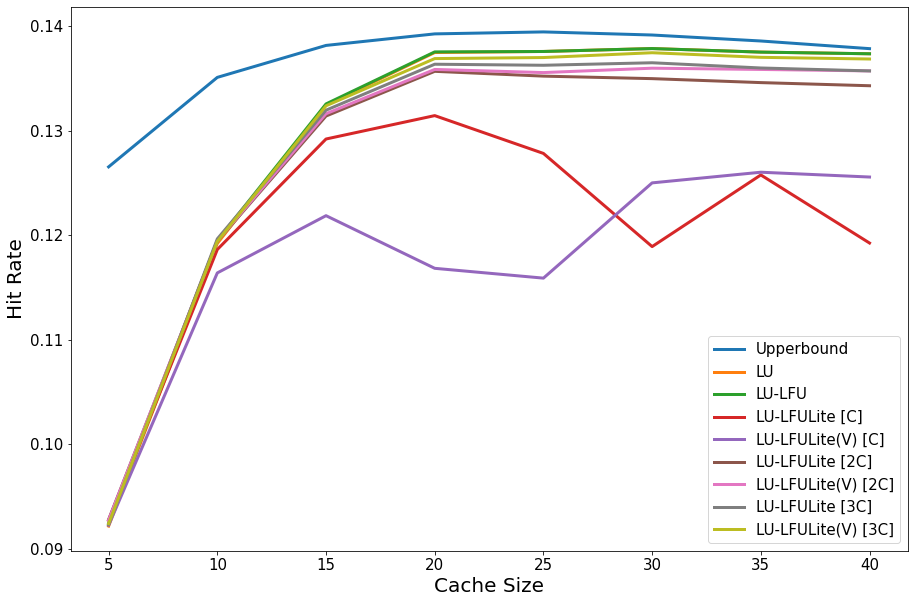

In [ ]:
x = cache

plt.figure(figsize=(15,10))

plt.plot(x, hit_rate9, label="Upperbound", linewidth=3)
plt.plot(x, hit_rate1, label="LU", linewidth=3)
plt.plot(x, hit_rate2, label = "LU-LFU", linewidth=3)
plt.plot(x, hit_rate3, label = "LU-LFULite [C]", linewidth=3)
plt.plot(x, hit_rate4, label = "LU-LFULite(V) [C]", linewidth=3)
plt.plot(x, hit_rate5, label = "LU-LFULite [2C]", linewidth=3)
plt.plot(x, hit_rate6, label = "LU-LFULite(V) [2C]", linewidth=3)
plt.plot(x, hit_rate7, label = "LU-LFULite [3C]", linewidth=3)
plt.plot(x, hit_rate8, label = "LU-LFULite(V) [3C]", linewidth=3)

plt.legend(loc = 'lower right', prop={"size":15})
plt.xlabel('Cache Size', fontsize=20)
plt.ylabel('Hit Rate', fontsize=20)
plt.xticks(size = 15)
plt.yticks(size = 15)
#plt.savefig('../plots/full_observation/single_cache/allluhit.eps')
plt.show()

In [ ]:

from scipy.optimize import minimize_scalar, minimize
import numpy as np
import random

# Cost Minimisation with Same Refresh Rate
class CMSR:
    def __init__(self, cache_size, beta, z, lambda_param, L, Cost, prob=[], mu_hat=[], C_hat=[]):
        """
        Cost : [C_f, C_ca, C_ch, C_o] = [fetching, additional caching, checking, constant]
        beta : Arrival Rate
        cache_size : Size of the Cache
        lambda_param : lambda parameter
        z: order of the lambda_ (Refresh rates of the library gets decreased)
        prob: Popularity profile of the contents in the library
        mu_hat: optimal refresh rate
        C_hat: optimal cache elements
        """
        self.prob = prob
        self.L = L
        self.cost = Cost
        self.cache_size = cache_size
        self.beta = beta
        self.lambda_param = lambda_param
        self.lambda_ = np.array([self.lambda_param/(i)**z for i in range(1,self.L+1)],dtype=np.float64) # Refresh rates of the contents
        self.C_hat = np.array(C_hat)                              # Current Cache
        self.C_old =  np.argsort(self.prob)[::-1][:self.cache_size]# Old cache
        self.firsttime = True
        self.mu_hat = self.minimize_cost()                       # Checking Rate of the cache
        self.firsttime = False
        self.cache_update()                                    # Calculated cache

    # Average System Cost
    def avg_sys_cost(self, rr):
        """
        Calculates the average system cost
        rr: Refresh rate of the cache
        Returns the average system cost
        """
        eps = 1e-15
        # if we are
        if not self.firsttime:
            d = self.C_hat
        else:
            d = self.C_old

        try:
            return self.beta*self.cost[0] + \
                        len(self.C_hat)*rr*self.cost[2] + \
                        rr*self.cost[1]*np.sum((self.lambda_[d])/(self.lambda_[d] + rr)) + \
                        self.beta*np.sum(self.prob[d]*((self.lambda_[d]*self.cost[-1]/(rr+eps))-self.cost[0]))
        # if cache contains no elements
        except:
            return self.beta*self.cost[0]

    def minimize_cost(self):
        """
        Convex Constrained Minimisation of the average system Cost
        Returns the optimal refresh rate of the cache
        """
        return minimize_scalar(self.avg_sys_cost, bounds = (0, None)).x

    def marg_cost(self):
        """
        Calculates the marginal cost vector of the items in the library
        Returns the marginal cost vector
        """
        eps = 1e-15
        return self.mu_hat*self.cost[2] +\
            ((self.mu_hat*self.lambda_)/(self.lambda_ + self.mu_hat))*self.cost[1] + \
            self.beta*self.prob*(((self.cost[3]*self.lambda_)/(self.mu_hat+eps))-self.cost[0])

    def cache_update(self):
        """
        Updates the Cache according to the marginal cost
        """
        mc = self.marg_cost()
        sorted_mc = np.argsort(mc[mc<0])
        if len(sorted_mc) > self.cache_size:
            self.C_hat = sorted_mc[:self.cache_size]
        else:
            self.C_hat = sorted_mc

    def refreshrate_cache(self):
        """
        Calculates the optimal refresh rate of the cache and optimal cache after their convergence
        """
        while(not np.array_equal(self.C_hat, self.C_old)):
            self.C_old = self.C_hat
            self.mu_hat = self.minimize_cost()
            self.cache_update()

    def currcache(self):
        """
        Calculates and returns the current cache
        """
        self.refreshrate_cache()
        return self.C_hat

# Cost Minimization with Different Refresh Rates
# Variants of CMDR- CMDR: Popularity is given
#                   CMDRP: Popularity is not given and cache update according to popularity
#                   CMDRM: Popularity is not given and cache update according to marginal cost 
class CMDR:
    def __init__(self, cache_size, beta, z, lambda_param, L, Cost, cache_update = 'marg', seed = 7, prob = [], C_hat=[]):
        """
        Cost : [C_f, C_ca, C_ch, C_o] = [fetching, additional caching, checking, constant]
        beta : Arrival Rate
        cache_size : Size of the Cache
        lambda_param : lambda parameter
        prob: probability profile of the items in the library
        z: order of the lambda_ (Refresh rates of the library gets decreased)
        cache_update: 'marg' - updates the cache according to the which has the more negative marginal cost
                    'pop'- updates the cache according to the most popular items in the library.
        C_hat: optimal cache of length cache_size
        seed: seed for numpy and random
        """
        np.random.seed(seed)
        random.seed(seed)
        self.upd = cache_update
        self.L = L
        self.cost = Cost
        self.cache_size = cache_size
        self.beta = beta
        self.lambda_param = lambda_param
        self.lambda_ = np.array([self.lambda_param/(i)**z for i in range(1,self.L+1)],dtype=np.float64) # Refresh rates of the contents
        self.C_hat = np.array([], dtype='int') if len(C_hat) == 0 else C_hat
        self.mu_hat = np.array([random.uniform(0,i) for i in self.lambda_])
        # Setting Bounds for the cost minimisation
        self.bounds = [(0, i) for i in self.lambda_]
        if len(prob) == 0:
            self.prob = np.zeros((L,))
            self.arr = np.zeros((L,)) # arary Counter
            self.calpop = True
        else:
            self.prob = prob
            self.calpop = False
            self.minimize_cost()


    # Average System Cost
    def avg_sys_cost(self, rr):
        """
        Calculates the average system cost
        rr: Refresh rates of the cache elements
        Returns the average system cost
        """
        eps = 1e-15

        # For the empty cache it returns self.beta*self.cost[0]
        try:
            return self.beta*self.cost[0] + \
                    np.sum(rr[self.C_hat])*self.cost[2] + \
                    self.cost[1]*np.sum((rr[self.C_hat]*self.lambda_[self.C_hat])/(self.lambda_[self.C_hat] + rr[self.C_hat])) + \
                    self.beta*np.sum(self.prob[self.C_hat]*((self.lambda_[self.C_hat]*self.cost[-1]/(rr[self.C_hat]+eps))-self.cost[0]))
        except:
            return self.beta*self.cost[0]

    # Minimising the System Cost for the Cache size equal to the library size i.e., infinite Cache
    def avg_sys_cost_inf(self, rr):
        """
        Calculates the average system cost if cache consists of entire library
        rr: Refresh rates of the entire library
        Returns the average system cost
        """
        eps = 1e-15
        return self.beta*self.cost[0] + \
                        np.sum(rr)*self.cost[2] + \
                        self.cost[1]*np.sum((rr*self.lambda_)/(self.lambda_ + rr)) + \
                        self.beta*np.sum(self.prob*((self.lambda_*self.cost[-1]/(rr+eps))-self.cost[0]))

    # Convex Constrained Minimisation

    def minimize_cost(self):
        """
        Convex Constrained Minimisation of the average system Cost
        Returns the optimal refresh rates of the cache
        """
        # x0 - initial values for the cost minimization
        return minimize(self.avg_sys_cost, x0=self.mu_hat[self.C_hat], bounds=[self.bounds[i] for i in self.C_hat]).x


    # Caluclates the marginal cost vector and returns it
    def marg_cost(self):
        """
        Calculates the marginal cost vector of the items in the library
        Returns the marginal cost vector
        """
        eps = 1e-15
        return self.mu_hat*self.cost[2] +\
            ((self.mu_hat*self.lambda_)/(self.lambda_ + self.mu_hat))*self.cost[1] + \
            self.beta*self.prob*(((self.cost[3]*self.lambda_)/(self.mu_hat+eps))-self.cost[0])

    def cache_update(self, req):
        """
        Updates the cache
        req: Request
        """
        if len(self.C_hat) < self.cache_size:
            if req not in self.C_hat:
                self.C_hat = np.append(self.C_hat, req)
        else:
            self.mu_hat[self.C_hat] = self.minimize_cost()
            if self.upd == 'marg':
                if req not in self.C_hat:
                    mc = self.marg_cost()
                    item_rem = self.C_hat[np.argmax(mc[self.C_hat])]
                    if mc[item_rem] > mc[req]:
                        self.C_hat = np.delete(self.C_hat, np.where(self.C_hat == item_rem))
                        self.C_hat = np.append(self.C_hat, req)
            elif self.upd == 'pop':
                self.C_hat = np.argsort(self.prob)[::-1][:self.cache_size]


    def counter_update(self, req):
        """
        Increases the counter of the library items
        req: Request
        """
        self.arr[req] += 1

    # Calculates the popularity distribution
    def currcache(self, req):
        """
        Calculates and Returns the current cache
        """
        if self.calpop:
            self.counter_update(req)
            self.prob = self.arr/np.sum(self.arr)
            self.cache_update(req)
        return self.C_hat

In [ ]:
def youtube(count=10_000, silent=True):
    """
    Loads the popularity profile from youtube data file and generates the requests

    count: No. of requests to be generated
    Returns the prob distribution and generated requests dictionary
    """
    #curr_path = Path(__file__).resolve().parents[1]
    data_path = "/content/youtubedata.pkl"

    start = time.time()
    with open( data_path,'rb') as f:
        prob = pickle.load(f)

    items = list(range(prob.shape[0]))
    # Random Sampling
    req = np.random.choice(items, p = prob, size = count)
    if not silent:
        print(f'TimeTaken:{time.time()-start}sec')
    return {'prob':prob, 'req':req}

In [ ]:
ytdata = youtube(count=50_000)
# Probability distribution
ytdataprob = ytdata['prob']
# Array of requests
ytdatareq = ytdata['req']

In [ ]:
#from cachingalgo.full_observation.cost_min import CMSR

# Initialising the algorithm
cache_size = 5

# Initialising the algorithm
alg = CMSR(cache_size=5, L=100, beta=10, z=1.5, lambda_param=5, Cost=[1, 0.1, 0.05, 0.025], prob=ytdataprob)

# To retrieve the cache
algcache = alg.currcache()

# To calculate the average system cost
avg_sys_cost = alg.avg_sys_cost(alg.mu_hat)

ValueError: ignored

In [ ]:
print(avg_sys_cost)

10.329796834841188
